#Node2Vec

In [57]:
import os

print(os.getcwd())

c:\Users\Usuario\Challenge-Reproducibilidad


In [2]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import networkx as nx

# Cargar el grafo desde el archivo
G = nx.read_weighted_edgelist('moreno_lesmis/out.moreno_lesmis_lesmis', 
                     comments='%',
                     create_using=nx.Graph())

# Cantidad de nodos y aristas en el grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")

# Ver un resumen del grafo
print("Nodos:", list(G.nodes))    
print("Aristas:", list(G.edges))  

Número de nodos: 77
Número de aristas: 254
Nodos: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '44', '45', '49', '50', '52', '56', '59', '65', '69', '70', '71', '72', '73', '17', '18', '19', '20', '21', '22', '23', '31', '42', '43', '51', '40', '41', '76', '55', '46', '53', '58', '63', '47', '48', '60', '61', '62', '64', '66', '67', '74', '75', '77', '57', '54', '68']
Aristas: [('1', '2'), ('2', '3'), ('2', '4'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('3', '4'), ('3', '11'), ('4', '11'), ('11', '12'), ('11', '13'), ('11', '14'), ('11', '15'), ('11', '16'), ('11', '24'), ('11', '25'), ('11', '26'), ('11', '27'), ('11', '28'), ('11', '29'), ('11', '30'), ('11', '32'), ('11', '33'), ('11', '34'), ('11', '35'), ('11', '36'), ('11', '37'), ('11', '38'), ('11', '39'), ('11', '44'), ('11', '45'), ('11', '49'), ('11

In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


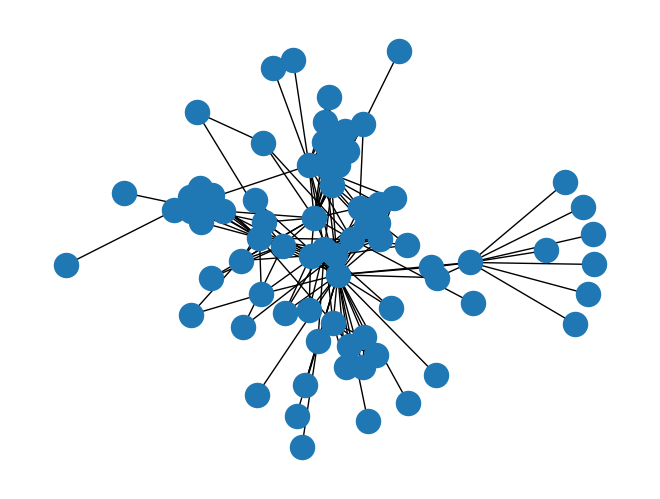

In [64]:
import matplotlib
nx.draw(G)

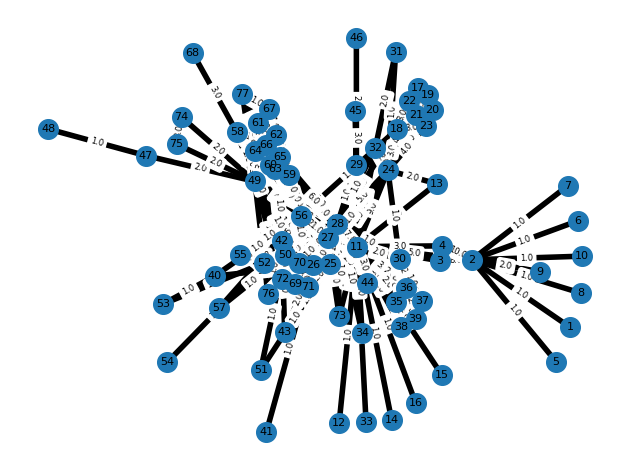

In [65]:
# Visualizemos el grafo con sus pesos
import matplotlib.pyplot as plt

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=10)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

ax = plt.gca()
ax.margins(0.02)
plt.axis("off")
plt.tight_layout()
plt.show()

In [66]:
#Implementacion del First Order Random Walk
def random_walk_FO(graph, start_node, walk_length):
    import random
    walk = [start_node]
    current_node = start_node
    
    for _ in range(walk_length):
        neighbors = [n for n in G.neighbors(current_node)] #Listamos todos los vecinos del nodo
        if not neighbors:
            break

        total_weight = 0
        individual_weights = []
        for i in neighbors:
            total_weight = total_weight + G.get_edge_data(current_node,i)['weight'] #Calculamos la suma de los pesos de los vecinos
            individual_weights.append(G.get_edge_data(current_node,i)['weight']) #Guardamos los pesos de cada arista en una lista

        probs = [w / total_weight for w in individual_weights] #Normalizamos las probabilidades

        current_node = random.choices(neighbors,weights=probs, k=1)[0] #Hacemos la decisión random, pero teniendo en cuenta las probabilidades
        walk.append(current_node)
    
    return walk

In [67]:
walk = random_walk_FO(G,"2",10)
print(walk)

['2', '4', '11', '28', '11', '2', '4', '2', '4', '3', '2']


In [68]:
#Implementacion del Second Order Random Walk
def random_walk_SO(graph, start_node, walk_length, q, p):
    import random
    walk = [start_node]
    current_node = start_node
    previous_node = start_node
    
    for _ in range(walk_length):
        neighbors = [n for n in G.neighbors(current_node)] #Listamos todos los vecinos del nodo
        if not neighbors:
            break

        total_weight = 0
        individual_weights = []
        for i in neighbors:
            #Calculamos el alpha para controlar el retorno y el in-out del camino
            d = nx.shortest_path_length(G,source=previous_node,target=i)
            if d == 0:
                alpha = 1/p
            elif d == 1:
                alpha = 1
            elif d == 2:
                alpha = 1/q
            
            total_weight = total_weight + alpha*G.get_edge_data(current_node,i)['weight'] #Calculamos la suma de los pesos de los vecinos con el factor alpha
            individual_weights.append(alpha*G.get_edge_data(current_node,i)['weight']) #Guardamos los pesos de cada arista en una lista con el factor alpha

        probs = [w / total_weight for w in individual_weights] #Normalizamos las probabilidades
        previous_node = current_node
        current_node = random.choices(neighbors,weights=probs, k=1)[0] #Hacemos la decisión random, pero teniendo en cuenta las probabilidades
        walk.append(current_node)

    return walk

In [69]:
walk = random_walk_SO(G,"2",10,0.5,0.5)
print(walk)

['2', '3', '2', '3', '4', '2', '4', '2', '10', '2', '11']


In [71]:
#Implementación tomada de: https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py
import numpy as np
import random

def get_alias_edge(G, p, q, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs) 
		
def alias_setup(probs):
        '''
        Compute utility lists for non-uniform sampling from discrete distributions.
        Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
        for details
        '''
        K = len(probs)
        q = np.zeros(K)
        J = np.zeros(K, dtype=int)

        smaller = []
        larger = []
        for kk, prob in enumerate(probs):
            q[kk] = K*prob
            if q[kk] < 1.0:
                smaller.append(kk)
            else:
                larger.append(kk)

        while len(smaller) > 0 and len(larger) > 0:
            small = smaller.pop()
            large = larger.pop()

            J[small] = large
            q[large] = q[large] + q[small] - 1.0
            if q[large] < 1.0:
                smaller.append(large)
            else:
                larger.append(large)

        return J, q


def alias_draw(J, q):
        '''
        Draw sample from a non-uniform discrete distribution using alias sampling.
        '''
        K = len(J)

        kk = int(np.floor(np.random.rand()*K))
        if np.random.rand() < q[kk]:
            return kk
        else:
            return J[kk]    


def preprocess_transition_probs(G):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		is_directed = nx.is_directed(G)

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = get_alias_edge(G,1,1,edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = get_alias_edge(G,1,1,edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = get_alias_edge(G,1,1,edge[1], edge[0])

		G.alias_nodes = alias_nodes
		G.alias_edges = alias_edges
	
		return         

def node2vec_walk(G, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		alias_nodes = G.alias_nodes
		alias_edges = G.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

def simulate_walks(G, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		walks = []
		nodes = list(G.nodes())
		print('Walk iteration:')
		for walk_iter in range(num_walks):
			print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(node2vec_walk(G,walk_length=walk_length, start_node=node))

		return walks   

In [16]:
%pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ----- ---------------------------------- 3.1/24.0 MB 16.8 MB/s eta 0:00:02
   ------ --------------------------------- 4.2/24.0 MB 10.9 MB/s eta 0:00:02
   --------- ------------------------------ 5.8/24.0 MB 9.3 MB/s eta 0:00:02
   ------------ --------------------------- 7.6/24.0 MB 9.0 MB/s eta 0:00:02
   --------------- ------------------------ 9.4/24.0 MB 8.9 MB/s eta 0:00:02
   ------------------ --------------------- 11.3/24.0 MB 8.9 MB/s eta 0:00:02
   --------------------- ------------------ 13.1/24.0 MB 9.0 MB/s eta 0:00:02
   ------------------------ --------------- 14.9/24.0 MB 8.8 MB/s eta 0:00:02
   --------------------------- ------------ 16.5/24.0 MB 8.7 MB/s eta 0:00:01
   ------------------------------ --------- 18.4/24.0 MB 8.6 MB/s eta 0:00:01
   --------------------------------- ------ 19.9/24.0 MB 8.5 MB/s eta 0:00:01
   ------------------------------------ --- 21.8/24.0 MB 8.5 MB/s eta 0:00:

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
%pip install --upgrade numpy gensim

  Using cached numpy-2.2.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
#Implementación tomada de: https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py
def learn_embeddings(walks, filename="les_miserables.emb"):
	'''
	Learn embeddings by optimizing the Skipgram objective using SGD.
	'''
	from gensim.models import Word2Vec
	walks = [list(map(str, walk)) for walk in walks]
	model = Word2Vec(walks, vector_size=16, window=10, min_count=0, sg=1, workers=8, epochs=1)
	model.wv.save_word2vec_format(filename)
	
	return

preprocess_transition_probs(G)
walks = simulate_walks(G,10,80)
learn_embeddings(walks)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [73]:
from gensim.models import KeyedVectors

# Cargar el modelo
model = KeyedVectors.load_word2vec_format("les_miserables.emb", binary=False)

# Nodos más similares a uno en específico
similar_nodes = model.most_similar("1", topn=10)
print(f"Nodos más similares a '1':")
for similar_node, similarity in similar_nodes:
    print(f"{similar_node}: {similarity}")

Nodos más similares a '1':
6: 0.9913234114646912
8: 0.9908105731010437
10: 0.9906865358352661
7: 0.9901820421218872
5: 0.9884644150733948
4: 0.9869530200958252
9: 0.9838376641273499
2: 0.9833080172538757
3: 0.9746944904327393
34: 0.8420562148094177


In [22]:
%pip install scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.1 MB 9.3 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.1 MB 11.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 13.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


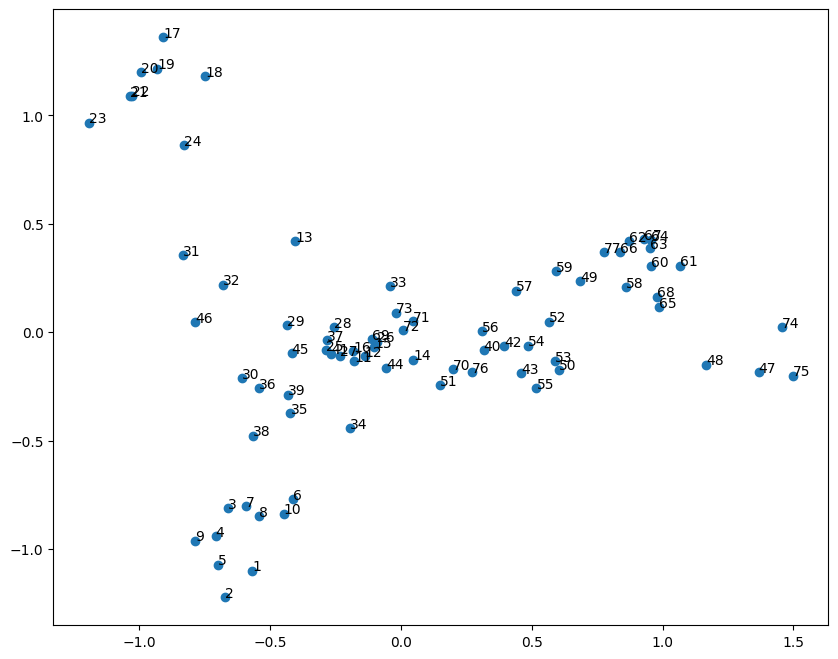

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ver el grafo luego de realizar node2vec

# Reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform([model[node] for node in model.key_to_index.keys()])

# Graficar
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

# Etiquetar
for i, node in enumerate(model.key_to_index.keys()):
    plt.annotate(node, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.show()

Ahora, aseguremonos que el algoritmo pueda representar homophily(comunidades en el grafo) y structural equivalence (roles estructurales de nodos)

In [99]:
def preprocess_transition_probs_homophily(G):
        is_directed = nx.is_directed(G)

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = get_alias_edge(G, 1, 0.5, edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = get_alias_edge(G, 1, 0.5, edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = get_alias_edge(G, 1, 0.5, edge[1], edge[0])

        G.alias_nodes = alias_nodes
        G.alias_edges = alias_edges
        return

preprocess_transition_probs_homophily(G)
walks = simulate_walks(G, 10, 80)
learn_embeddings(walks, "les_miserables_homophily.emb")
model_homophily = KeyedVectors.load_word2vec_format("les_miserables_homophily.emb", binary=False)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [93]:
def preprocess_transition_probs_structural(G):
        is_directed = nx.is_directed(G)

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = get_alias_edge(G, 1, 2, edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = get_alias_edge(G, 1, 2, edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = get_alias_edge(G, 1, 2, edge[1], edge[0])

        G.alias_nodes = alias_nodes
        G.alias_edges = alias_edges
        return

preprocess_transition_probs_structural(G)
walks = simulate_walks(G, 10, 80)
learn_embeddings(walks, "les_miserables_structural.emb")
model_structural = KeyedVectors.load_word2vec_format("les_miserables_structural.emb", binary=False)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


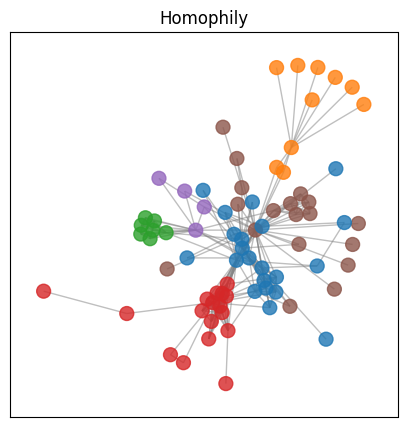

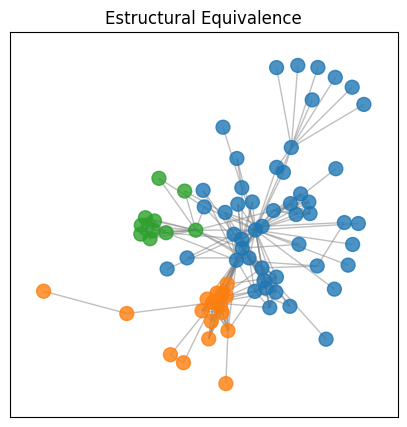

In [100]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def visualizar_grafo(G, model, n_clusters, title):
    # Reducimos la dimensionalidad
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform([model[node] for node in model.key_to_index.keys()])
    
    # Aplicamos KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_vectors)

    # Mapeo de nodos a clusters
    cluster_map = {str(node): labels[idx] for idx, node in enumerate(model.key_to_index.keys())}
    
    # Colormap
    cmap = plt.colormaps.get_cmap('tab10')
    node_colors = [cmap(cluster_map[str(node)]) for node in G.nodes()]

    # Graficamos
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    
    plt.title(title)
    plt.show()

# Grafo para Homophily (p=1, q=0.5) - 6 Clusters
visualizar_grafo(G, model_homophily, 6, "Homophily")

# Grafo para Structural Equivalence (p=1, q=2) - 3 Clusters
visualizar_grafo(G, model_structural, 3, "Estructural Equivalence")